#WCGAN with LSTM as classifier

## Importing Libraries

In [ ]:
import os
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
from sklearn.utils import shuffle
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            confusion_matrix

In [ ]:
import tensorflow as tf
tf.config.run_functions_eagerly(True)


## EDA

In [ ]:
df=pd.read_csv('./creditcard.csv')
df=df.drop('Time',axis=1)
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      284807 non-null  float64
 1   V2      284807 non-null  float64
 2   V3      284807 non-null  float64
 3   V4      284807 non-null  float64
 4   V5      284807 non-null  float64
 5   V6      284807 non-null  float64
 6   V7      284807 non-null  float64
 7   V8      284807 non-null  float64
 8   V9      284807 non-null  float64
 9   V10     284807 non-null  float64
 10  V11     284807 non-null  float64
 11  V12     284807 non-null  float64
 12  V13     284807 non-null  float64
 13  V14     284807 non-null  float64
 14  V15     284807 non-null  float64
 15  V16     284807 non-null  float64
 16  V17     284807 non-null  float64
 17  V18     284807 non-null  float64
 18  V19     284807 non-null  float64
 19  V20     284807 non-null  float64
 20  V21     284807 non-null  float64
 21  V22     28

PCA Transformation: The description of the data says that all the features went through a PCA transformation (Except for time and amount).  
Scaling: Keep in mind that in order to implement a PCA transformation features need to be previously scaled.

In [ ]:
df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,2.239053e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [ ]:
# checking for duplicate values
print(f"Dataset has {df.duplicated().sum()} duplicate rows")
# dropping duplicate rows
df.drop_duplicates(inplace=True)

Dataset has 9144 duplicate rows


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 275663 entries, 0 to 284806
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   V1      275663 non-null  float64
 1   V2      275663 non-null  float64
 2   V3      275663 non-null  float64
 3   V4      275663 non-null  float64
 4   V5      275663 non-null  float64
 5   V6      275663 non-null  float64
 6   V7      275663 non-null  float64
 7   V8      275663 non-null  float64
 8   V9      275663 non-null  float64
 9   V10     275663 non-null  float64
 10  V11     275663 non-null  float64
 11  V12     275663 non-null  float64
 12  V13     275663 non-null  float64
 13  V14     275663 non-null  float64
 14  V15     275663 non-null  float64
 15  V16     275663 non-null  float64
 16  V17     275663 non-null  float64
 17  V18     275663 non-null  float64
 18  V19     275663 non-null  float64
 19  V20     275663 non-null  float64
 20  V21     275663 non-null  float64
 21  V22     275663 

There is no null values

In [ ]:
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


<Axes: xlabel='Class', ylabel='count'>

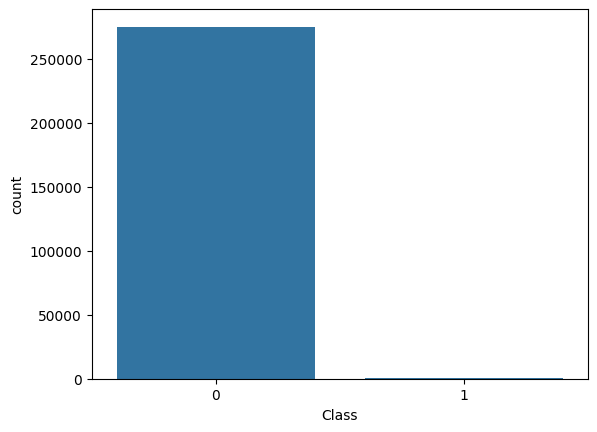

In [ ]:
sns.countplot(data=df,x='Class')

In [ ]:
df.drop('Class',axis=1).skew()

,0
V1,-3.273070
V2,-4.653486
V3,-2.216730
V4,0.681387
V5,-2.458790
V6,1.867576
V7,2.877722
V8,-8.292631
V9,0.550965
V10,1.242165


## Scaling

In [ ]:
scaler = StandardScaler()
X = scaler.fit_transform(df.drop('Class', axis=1))
y = df['Class'].values
print(X.shape, y.shape)

(275663, 29) (275663,)


## Splitting the data

we want to test our models on the original testing set not on the testing set created from GAN. The main goal is to fit the model in the generated data, and test it on the original testing set.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Testing baseline model with original data

# GAN

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, Concatenate
from tensorflow.keras.optimizers import Adam

def gradient_penalty(critic, real, fake, cond, gp_weight):
    # real, fake, cond are tf.Tensors of shape (batch, dim)
    batch_size = tf.shape(real)[0]
    alpha = tf.random.uniform([batch_size, 1], 0.0, 1.0)
    diff = fake - real
    interp = real + alpha * diff

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interp)
        pred = critic([interp, cond], training=True)
    grads = gp_tape.gradient(pred, interp)
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=1) + 1e-12)
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    return gp_weight * gp

class CWGAN_GP:
    def __init__(self,
                 data_dim=29,
                 cond_dim=2,
                 latent_dim=100,
                 gp_weight=10.0,
                 n_critic=5,
                 batch_size=64):
        self.data_dim   = data_dim
        self.cond_dim   = cond_dim
        self.latent_dim = latent_dim
        self.gp_weight  = gp_weight
        self.n_critic   = n_critic
        self.batch_size = batch_size

        self._build_generator()
        self._build_critic()
        self.gen_opt  = Adam(1e-4, beta_1=0.0, beta_2=0.9)
        self.crit_opt = Adam(1e-4, beta_1=0.0, beta_2=0.9)

    def _build_generator(self):
        z = Input((self.latent_dim,), name='z')
        c = Input((self.cond_dim,), name='c')
        x = Concatenate()([z, c])
        for units in [256, 512, 512]:
            x = Dense(units)(x)
            x = LeakyReLU(0.2)(x)
            x = BatchNormalization()(x)
        out = Dense(self.data_dim, activation='linear')(x)
        self.generator = Model([z, c], out, name='generator')

    def _build_critic(self):
        x_in = Input((self.data_dim,), name='x')
        c_in = Input((self.cond_dim,), name='c')
        x = Concatenate()([x_in, c_in])
        for units in [512, 512, 256]:
            x = Dense(units)(x)
            x = LeakyReLU(0.2)(x)
        out = Dense(1)(x)
        self.critic = Model([x_in, c_in], out, name='critic')

    def train(self, real_data, real_cond, epochs=10000):
        # real_data: np.array shape (N, data_dim)
        # real_cond: tf.Tensor shape (N, cond_dim), one-hot
        N = real_data.shape[0]

        for epoch in range(epochs):
            # --- Train critic ---
            for _ in range(self.n_critic):

                idx      = np.random.randint(0, N, self.batch_size)
                real_x   = tf.convert_to_tensor(real_data[idx], dtype=tf.float32)
                cond_x   = tf.gather(real_cond, idx)


                z_noise  = tf.random.normal((self.batch_size, self.latent_dim))
                fake_idx = np.random.randint(0, N, self.batch_size)
                cond_z   = tf.gather(real_cond, fake_idx)
                fake_x   = self.generator([z_noise, cond_z], training=True)

                gp = gradient_penalty(self.critic, real_x, fake_x, cond_x, self.gp_weight)

                with tf.GradientTape() as tape:
                    crit_real = self.critic([real_x, cond_x], training=True)
                    crit_fake = self.critic([fake_x, cond_z], training=True)
                    loss_crit = tf.reduce_mean(crit_fake) - tf.reduce_mean(crit_real) + gp
                grads = tape.gradient(loss_crit, self.critic.trainable_variables)
                self.crit_opt.apply_gradients(zip(grads, self.critic.trainable_variables))

            # --- Train generator ---
            z_noise  = tf.random.normal((self.batch_size, self.latent_dim))
            fake_idx = np.random.randint(0, N, self.batch_size)
            cond_z   = tf.gather(real_cond, fake_idx)
            with tf.GradientTape() as tape:
                fake_x   = self.generator([z_noise, cond_z], training=True)
                crit_fake= self.critic([fake_x, cond_z], training=True)
                loss_gen = -tf.reduce_mean(crit_fake)
            grads = tape.gradient(loss_gen, self.generator.trainable_variables)
            self.gen_opt.apply_gradients(zip(grads, self.generator.trainable_variables))

            if epoch % 100 == 0:
                print(f"Epoch {epoch:5d} | Critic loss: {loss_crit:.4f} | Gen loss: {loss_gen:.4f}")


In [ ]:

cwgan_gp = CWGAN_GP(
    data_dim   = X_train.shape[1],
    cond_dim   = 2,                # e.g. [fraud, non-fraud]
    latent_dim = 100,
    gp_weight  = 10.0,
    n_critic   = 5,
    batch_size = 64
)


y_flat    = tf.reshape(y_train, [-1])              # (N,)
y_one_hot = tf.one_hot(tf.cast(y_flat, tf.int32), 2)  # shape (N,2)


cwgan_gp.train(X_train, y_one_hot, epochs=1000)


Epoch     0 | Critic loss: 6.1594 | Gen loss: 0.5389
Epoch   100 | Critic loss: 1749.7386 | Gen loss: 9.7976
Epoch   200 | Critic loss: 146398.2500 | Gen loss: 68.1121
Epoch   300 | Critic loss: 4869519.0000 | Gen loss: 253.5537
Epoch   400 | Critic loss: 41356952.0000 | Gen loss: 797.0583
Epoch   500 | Critic loss: 226913696.0000 | Gen loss: 1596.1040
Epoch   600 | Critic loss: 1256708608.0000 | Gen loss: 3721.0986
Epoch   700 | Critic loss: 4447620096.0000 | Gen loss: 8257.6602
Epoch   800 | Critic loss: 11373171712.0000 | Gen loss: 10752.3740
Epoch   900 | Critic loss: 30179147776.0000 | Gen loss: 17612.4922


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

print("Latent dim:", cwgan_gp.latent_dim)


n_synth = 250_000
noise = np.random.normal(0, 1, size=(n_synth, cwgan_gp.latent_dim)).astype(np.float32)



c_fake = np.tile(np.array([[1, 0]], dtype=np.float32), (n_synth, 1))


gen_samples = cwgan_gp.generator.predict([noise, c_fake], verbose=0)
print("Raw synthetic shape:", gen_samples.shape)


scaler = StandardScaler().fit(df.drop("Class", axis=1).values)
gen_orig = scaler.inverse_transform(gen_samples)
print("Inverted synthetic shape:", gen_orig.shape)


gen_df = pd.DataFrame(gen_orig, columns=df.drop("Class", axis=1).columns)
print(gen_df.head())


gen_X_train = np.vstack([X_train, gen_samples])
print("Augmented X shape:", gen_X_train.shape)


y_train_col = y_train.reshape(-1,1) if y_train.ndim == 1 else y_train
gen_y = np.ones((n_synth,1), dtype='int32')
gen_y_train = np.vstack([y_train_col, gen_y])
print("Augmented y shape:", gen_y_train.shape)


Latent dim: 100


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



Raw synthetic shape: (250000, 29)
Inverted synthetic shape: (250000, 29)
         V1        V2        V3        V4        V5        V6        V7  \
0  0.176474 -0.394330 -0.902790 -0.426996  0.885975  1.415545 -0.948280   
1 -2.114972  1.107313  1.075585  0.207257  0.645882 -0.474703  0.851607   
2 -1.771634 -0.061711 -0.489841 -1.893682  0.809910 -0.860694  1.208958   
3  0.709856 -0.172263 -0.244382 -0.019011 -0.118777 -0.100425 -0.402771   
4  0.698901  0.468744  1.679835  1.595551  0.914408  0.601256  0.060458   

         V8        V9       V10  ...       V20       V21       V22       V23  \
0  0.628823 -0.443122  0.841710  ... -0.181474  0.214101  0.455056  0.334509   
1  0.297458 -0.818430  0.209111  ...  0.026200 -0.579763 -0.922995  0.354394   
2  0.174002 -2.128227 -0.212802  ...  0.001454 -0.012900 -0.248927  0.027330   
3  0.247793  0.211299  0.649931  ...  0.015810  0.749463  1.648456 -0.634775   
4  0.050042  0.850141 -0.299759  ... -0.127157  0.408211  0.355817 -0.164110

#Training GAN

## Testing baseline model with generated data

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        16,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,051 (62.70 KB)

 Trainable params: 16,051 (62.70 KB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning:

Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.



Epoch 1/5
14704/14704 ━━━━━━━━━━━━━━━━━━━━ 3949s 269ms/step - loss: 0.0819 - pr_auc: 0.9858 - precision: 0.9520 - recall: 0.9738 - roc_auc: 0.9840 - val_loss: 0.0045 - val_pr_auc: 0.6240 - val_precision: 0.7416 - val_recall: 0.6947 - val_roc_auc: 0.8934
Epoch 2/5
14704/14704 ━━━━━━━━━━━━━━━━━━━━ 3987s 269ms/step - loss: 0.0022 - pr_auc: 0.9999 - precision: 0.9998 - recall: 0.9994 - roc_auc: 0.9999 - val_loss: 0.0038 - val_pr_auc: 0.7354 - val_precision: 0.8333 - val_recall: 0.7368 - val_roc_auc: 0.9097
Epoch 3/5
14704/14704 ━━━━━━━━━━━━━━━━━━━━ 3998s 270ms/step - loss: 0.0015 - pr_auc: 1.0000 - precision: 0.9998 - recall: 0.9997 - roc_auc: 0.9999 - val_loss: 0.0035 - val_pr_auc: 0.7779 - val_precision: 0.8333 - val_recall: 0.7368 - val_roc_auc: 0.9304
Epoch 4/5
14704/14704 ━━━━━━━━━━━━━━━━━━━━ 4055s 275ms/step - loss: 0.0017 - pr_auc: 0.9999 - precision: 0.9998 - recall: 0.9996 - roc_auc: 0.9999 - val_loss: 0.0034 - val_pr_auc: 0.7880 - val_precision: 0.8235 - val_recall: 0.7368 - val_

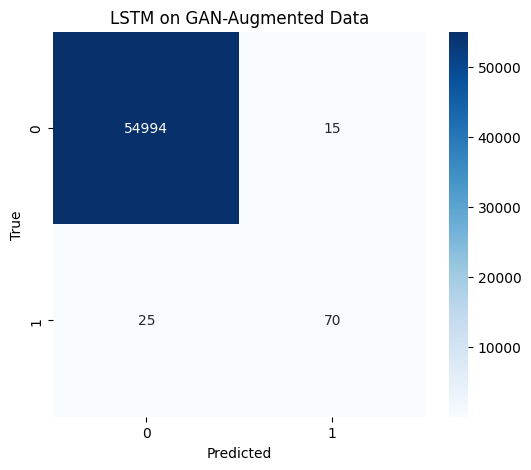

In [ ]:

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall, AUC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


y_train_flat = gen_y_train.ravel()  # shape (N_train,)


def create_sequences(X, y, seq_len):
    sequences, labels = [], []
    for i in range(len(X) - seq_len + 1):
        sequences.append(X[i : i + seq_len])
        labels.append(y[i + seq_len - 1])
    return np.array(sequences), np.array(labels)



SEQ_LEN = 30
BATCH   = 32

X_seq_train, y_seq_train = create_sequences(gen_X_train, y_train_flat, seq_len=SEQ_LEN)
X_seq_test, y_seq_test = create_sequences(X_test, y_test, seq_len=SEQ_LEN)


# Build the LSTM classifier
n_features = gen_X_train.shape[1]

model = Sequential([
    tf.keras.Input(shape=(SEQ_LEN, n_features)),
    LSTM(50),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=Adam(2e-4),
    loss='binary_crossentropy',
    metrics=[
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='roc_auc'),
        AUC(name='pr_auc', curve='PR')
    ]
)

model.summary()


history = model.fit(
    X_seq_train, y_seq_train,
    epochs=5,
    validation_data=(X_seq_test, y_seq_test)
)


y_prob = model.predict(X_seq_test).ravel()
y_pred = (y_prob > 0.5).astype(int)
y_true = y_seq_test # aligned 1D array of length N_test - SEQ_LEN

print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("LSTM on GAN-Augmented Data")
plt.show()

Referneces-[A hybrid deep learning approach with generative adversarial network for credit card fraud detection](https://doi.org/10.3390/technologies12100186), [Improving detection of credit card fraudulent transactions using generative adversarial networks](https://arxiv.org/abs/1907.03355),https://www.kaggle.com/code/shiratorizawa/wcgan, [ The importance of future information in credit card fraud detection](https://arxiv.org/abs/2204.05265), https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/code

The Wasserstein GAN (WCGAN) combined with LSTM yields strong performance in fraud detection, though slightly weaker than standard GAN + LSTM.

The confusion matrix shows 70 fraud cases correctly detected, while 25 frauds were missed (false negatives) and 15 legitimate transactions were misclassified as fraud (false positives) out of over 55,000 cases.

The classification report indicates precision = 0.8235 and recall = 0.7368 for fraud detection, leading to an F1-score = 0.7778.

Accuracy remains extremely high at 99.93%, with the model handling the class imbalance effectively.

Compared to GAN + LSTM, WCGAN + LSTM shows a drop in recall, meaning it misses more fraud cases, though precision remains strong.

Overall, WCGAN + LSTM is effective, achieving high precision and competitive overall performance, but it sacrifices recall relative to GAN + LSTM, making it less effective at catching all fraud cases.

Note- ChatGPT used for understanding results and on error in the main wcgan model based on the gradient penalty and how it used and  help with lstm code to use less memory.